# IMPORT

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

In [2]:
df = pd.read_csv("/Users/eunhyokim/Desktop/SILAB/ml-study/log.csv")

In [3]:
df

,A,B,C,D,E,score
0,0.073151,0.285306,0.951622,0.383950,0.930751,64.383835
1,0.649773,0.176054,0.072235,0.652499,0.563998,77.706220
2,0.738418,0.622323,0.498137,0.584917,0.368593,81.913086
3,0.828920,0.412070,0.393104,0.089638,0.296538,70.917984
4,0.225096,0.248871,0.678106,0.979382,0.288178,70.506940
...,...,...,...,...,...,...
9992,0.957076,0.784606,0.970457,0.773066,0.634099,69.645996
9993,0.886581,0.475012,0.284580,0.247334,0.192479,74.719150
9994,0.797169,0.580464,0.895559,0.046293,0.608271,66.929970
9995,0.999686,0.027524,0.598845,0.682025,0.396211,72.006240


# EDA

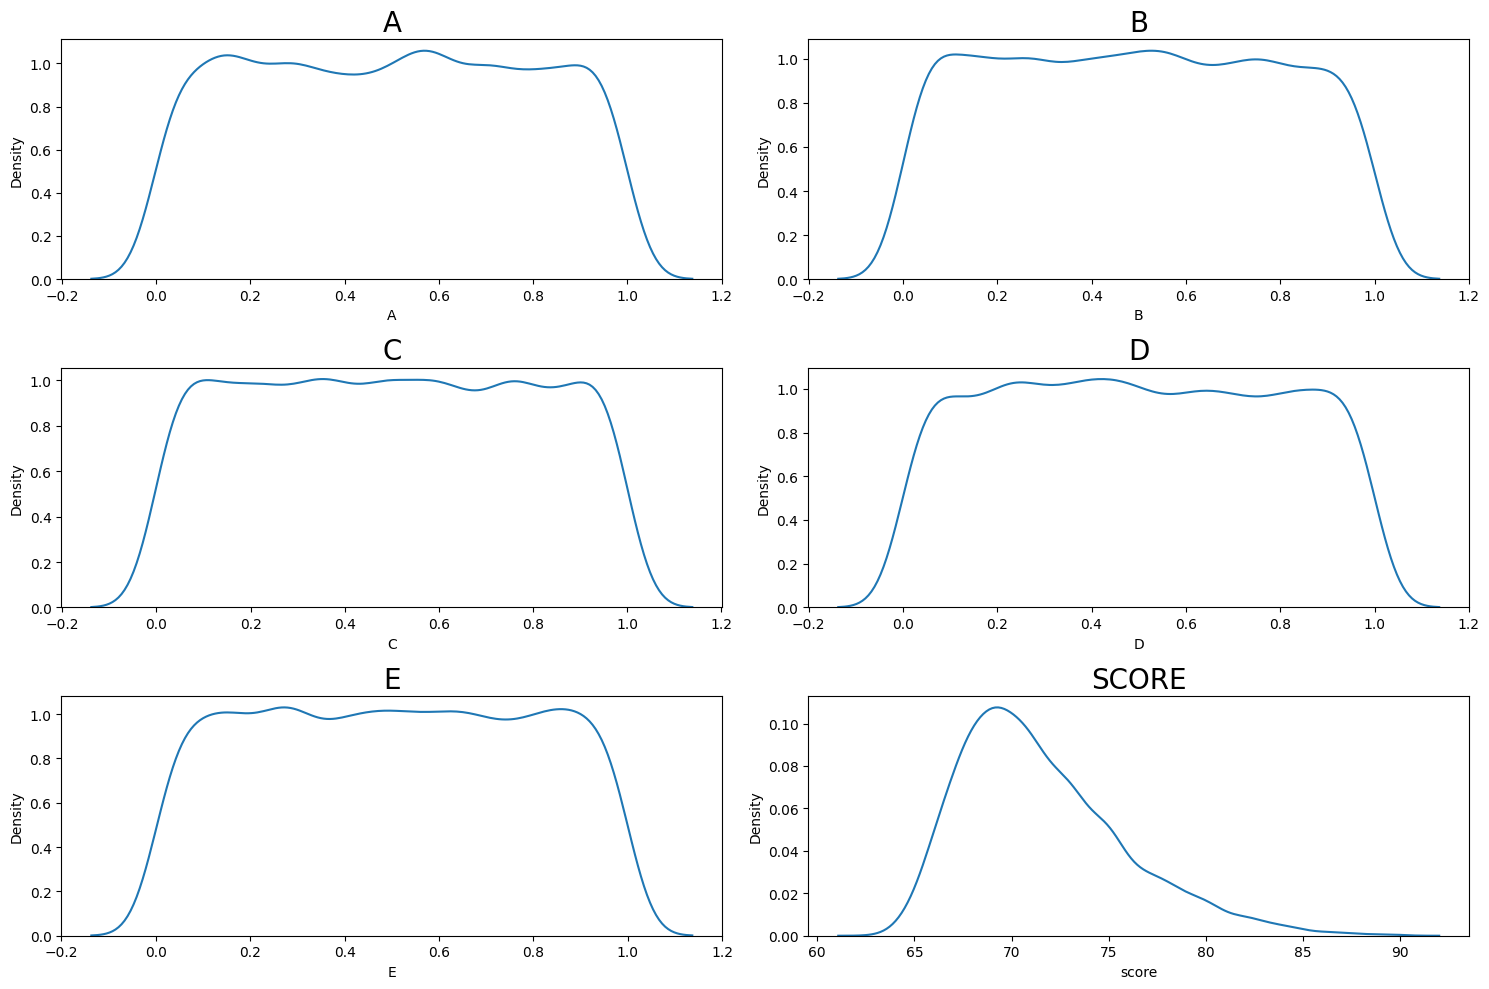

In [5]:
# static information visualization
fig = plt.figure(figsize=(15, 10))
for idx, item in enumerate(['A', 'B', 'C', 'D', 'E', 'score']):
    ax = fig.add_subplot(3, 2, idx+1)
    ax.set_title(item.replace('_', ' ').upper(), size=20)
    sns.kdeplot(df[item])

plt.tight_layout()
# x는 Uniform, y는 poisson/chi2

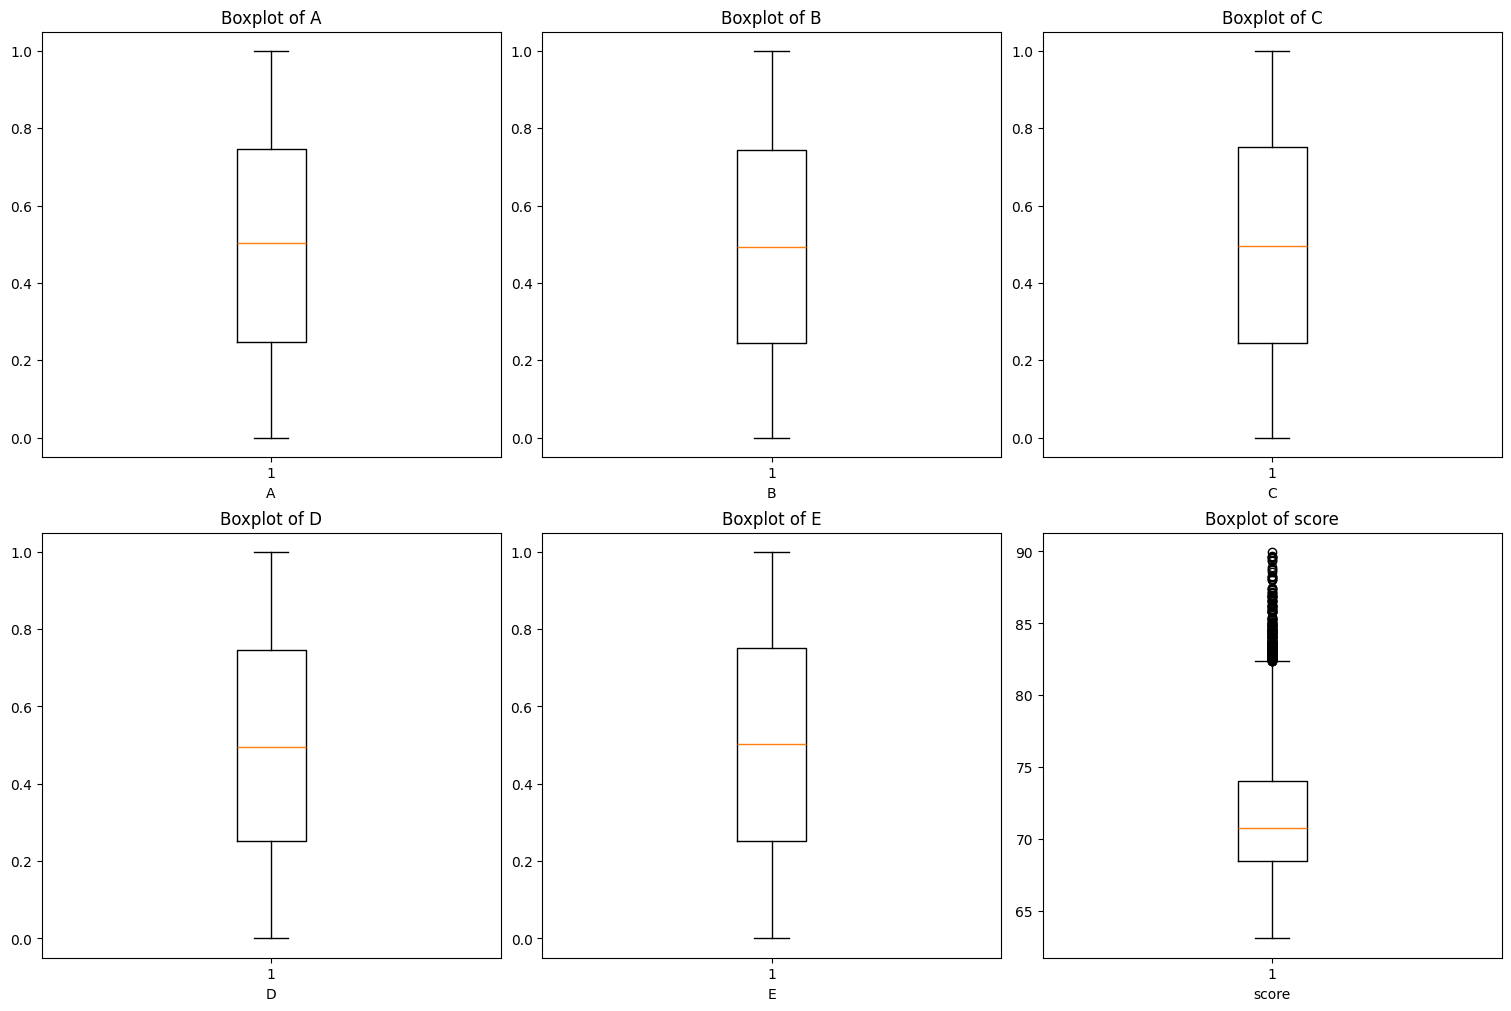

In [21]:

# 서브플롯 그리기
fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # 2D 배열을 1D 배열로 변환

for i, col in enumerate(list(df.columns)):
    axes[i].boxplot(df[col], vert=True)
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

plt.show()

# preprocessing

In [31]:
q1 = df['score'].quantile(0.25)
q3 = df['score'].quantile(0.75)
iqr = q3 - q1
ub = q3 + 1.5 * iqr
lb = q3 - 1.5 * iqr
df_modi = df.query("score <= @ub & score >= @lb")


In [32]:
X = df_modi.drop('score', axis = 1).to_numpy()
y = df_modi['score'].to_numpy().reshape((-1,1))

In [34]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.7, random_state=42, shuffle=True)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

# model

In [38]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(5, 15, bias=True) # 입력층(5) -> 은닉층1(15)으로 가는 연산
        self.fc2 = nn.Linear(15, 10, bias=True) # 은닉층1(15) -> 은닉층2(10)으로 가는 연산
        self.fc3 = nn.Linear(10, 1, bias=True) # 은닉층2(10) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(15개의 20%인 3개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [39]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7) #learning rate:: gradient descent에서 step size #weight_decay:: 
#Adam: 학습률을 동적으로 조정 -> 제일 많이 떨어트리는 alpha값 구하나봄?

In [40]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    
    inputs, values = data # data에는 X, Y가 들어있다.

    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산

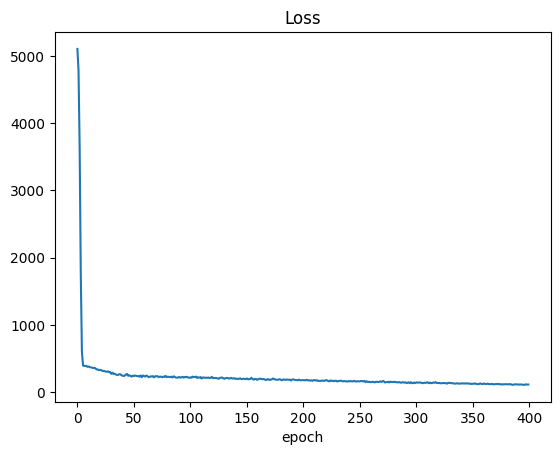

In [41]:
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [42]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [43]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:2.556262254714966
test rmse:2.589689254760742
